In [1]:
import os
import cv2
from cv2 import imread
from cv2 import imshow
from cv2 import CascadeClassifier
from cv2 import rectangle
import numpy as np
import pandas as pd
import imutils 
from imutils import paths
from skimage.feature import hog, greycomatrix, greycoprops
from skimage import data, segmentation, color, filters, exposure, restoration
from skimage.util import img_as_ubyte
from skimage.morphology import erosion, dilation, opening, closing, white_tophat
from skimage.morphology import black_tophat, skeletonize, convex_hull_image
from skimage.morphology import disk
import matplotlib.pyplot as plt

from scipy.signal import convolve2d as conv2
from scipy import ndimage as ndi

from sklearn import metrics
from skimage.data import gravel
from skimage.filters import difference_of_gaussians, window
from scipy.fftpack import fftn, fftshift
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import recall_score, f1_score, accuracy_score, precision_score
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn import svm
from sklearn.svm import SVC 
from sklearn.model_selection import train_test_split

from mtcnn.mtcnn import MTCNN
from matplotlib.patches import Rectangle
import tensorflow as tf
from zipfile import ZipFile
import pickle
from matplotlib import style
import seaborn as sns

# from skimage import data
# from skimage.color import rgb2gray


Using TensorFlow backend.


In [2]:
!pip install mtcnn

In [3]:
with tf.device('/device:GPU:0'):
    
    detector = MTCNN()

    base_path = 'I:/Thesis/dataset/final/train_modi - copy'
    categories = ['angry' ,'happy', 'sad', 'surprised']
    '''
    fig, axes = plt.subplots(ncols=3, figsize=(15, 3.5))
    ax = axes.ravel()
    ax[0] = plt.subplot(1, 3, 1)
    ax[1] = plt.subplot(1, 3, 2)
    ax[2] = plt.subplot(1, 3, 3)
    '''
    def bgr2rgb(img):
        return cv2.cvtColor(img.copy(), cv2.COLOR_BGR2RGB)
    # resize image
    def image_to_feature_vector(images, size=(150, 150)):
        return cv2.resize(images, size).flatten()

    def make(rc_img):
        '''
        fig, axes = plt.subplots(ncols=3, figsize=(15, 3.5))
        ax = axes.ravel()
        ax[0] = plt.subplot(1, 3, 1)
        ax[1] = plt.subplot(1, 3, 2)
        ax[2] = plt.subplot(1, 3, 3)
        '''
        selem = disk(20)
        eroded = erosion(rc_img, selem)
        roi = rc_img - eroded


#         h_gram = extract_color_histogram(roi)
        pixels = image_to_feature_vector(roi)

        rawImages.append(pixels)                   # features
        labels.append(cat)
#         features.append(h_gram)
        '''       
        ax[0].imshow(rc_img)
        ax[0].set_title('Original')
        ax[0].axis('off')

        ax[1].imshow(eroded)
        ax[1].set_title('Segmented pic')
        ax[1].axis('off')

    #     ax[2].hist(out.ravel(),256,[0,256], color='r')
    #     ax[2].set_title('Histogram')

        ax[2].imshow(roi, cmap=plt.cm.gray)
        ax[2].axis('off')

        plt.show()
        '''    


    labels = []
    rawImages = []
#     features = []

    c, b, f = 0,0,0
#     c = total number of images
#     b = detected human face
#     f = human face not found

    for cat in categories:

        image_dir = os.path.join(base_path, cat)
        imagePaths = list(paths.list_images(image_dir))

        for (i, imagePath) in enumerate(imagePaths):
            c=c+1
            '''
            fig, axes = plt.subplots(ncols=3, figsize=(15, 3.5))
            ax = axes.ravel()
            ax[0] = plt.subplot(1, 3, 1)
            ax[1] = plt.subplot(1, 3, 2)
            ax[2] = plt.subplot(1, 3, 3)
            '''

            image = cv2.imread(imagePath)[:,:,::-1]

            # perform face detection
            bboxes = detector.detect_faces(image)
    #         ax[2] = plt.gca()
            if list(bboxes):
                b=b+1

                # print bounding box for each detected face
                twidth, theight = 0, 0
                for box in bboxes:
                    x, y, width, height = box['box']

                    if width > twidth and height > theight:
                        twidth, theight = width, height
                        x2, y2 = x + twidth, y + theight
                        # draw a rectangle over the pixels
                        roi_image=image[y:y2, x:x2]
                        roi_image=roi_image[:,:,::-1]
                        roi_gray = cv2.cvtColor(roi_image, cv2.COLOR_BGR2GRAY)

    #                     rectangle(image, (x, y), (x2, y2), (0,255,0), 3)
    #                     rect = Rectangle((x, y),twidth, theight, fill=False, color='yellow')
                    else:
                        continue

                make(roi_gray)
                roi_flip = cv2.flip(roi_gray, 1)
                make(roi_flip)
#                 roi_rotate = cv2.rotate(roi_gray, cv2.cv2.ROTATE_90_CLOCKWISE)
#                 roi_rotate = imutils.rotate(roi_gray, angle=90)
#                 make(roi_rotate)

            else:
                f=f+1
                
        print(f"{cat}: c={c}, b={b}, f={f}")

    rawImages = np.array(rawImages)               # show some information on the memory consumed by the raw images matrix and features matrix
    labels = np.array(labels)
#     features = np.array(features)


angry: c=160, b=160, f=0
happy: c=376, b=376, f=0
sad: c=580, b=580, f=0
surprised: c=804, b=804, f=0


In [4]:
rawImages.size

36180000

In [5]:
X_train, X_test, y_train, y_test = train_test_split(rawImages, labels, test_size=0.25, random_state=30)
#     (train_Feat, test_Feat, train_Labels, test_Labels) = train_test_split(features, labels, test_size=0.25, random_state=30)

# Classifier before tuning

In [12]:
def train_model(model, name):
    model.fit(X_train,y_train)

    test_prediction = model.predict(X_test)
    train_prediction= model.predict(X_train)
    
    print("\n"+ name + "Classifier: \n")

    test_matrics = confusion_matrix(y_test, test_prediction)
    print("Confusion Matrix:\n", test_matrics)

    test_report = classification_report(y_test, test_prediction)
    print("Classification Report : \n", test_report)
    
    test_acc = accuracy_score(y_test, test_prediction)                     # test accuracy
    train_acc = accuracy_score(y_train, train_prediction)
    
    print("Accuracy of " + name + " : \n")
          
    print('Train Accuracy : {:.5f} %'.format(train_acc * 100))
    print('Test Accuracy : {:.5f} % \n'.format(test_acc * 100))
          
    print('Train Recall : ', recall_score(y_train, train_prediction, average='weighted'))
    print("Test Recall : ", recall_score(y_test, test_prediction, average='weighted'), '\n')
          
    print("Test F1 : ", f1_score(y_test, test_prediction, average='weighted'))
    print("Test precison : ", precision_score(y_test, test_prediction, average='weighted'))
    

    style.use('fivethirtyeight')
    sns.set(style='whitegrid', color_codes=True, font_scale=1.2)    # 'font_scale' = size of label 
    
    plt.figure(figsize=(6,4))
    sns.heatmap(test_matrics, annot=True, annot_kws={"size": 17}, fmt = "d")
    plt.show()

    return test_acc


Decision TreeClassifier: 

Confusion Matrix:
 [[31 13 30  3]
 [ 7 86 20  2]
 [12  5 80  0]
 [ 6 24 24 59]]
Classification Report : 
               precision    recall  f1-score   support

       angry       0.55      0.40      0.47        77
       happy       0.67      0.75      0.71       115
         sad       0.52      0.82      0.64        97
   surprised       0.92      0.52      0.67       113

    accuracy                           0.64       402
   macro avg       0.67      0.62      0.62       402
weighted avg       0.68      0.64      0.63       402

Accuracy of Decision Tree : 

Train Accuracy : 68.90547 %
Test Accuracy : 63.68159 % 

Train Recall :  0.6890547263681592
Test Recall :  0.6368159203980099 

Test F1 :  0.6329848667982095
Test precison :  0.6827166925114686


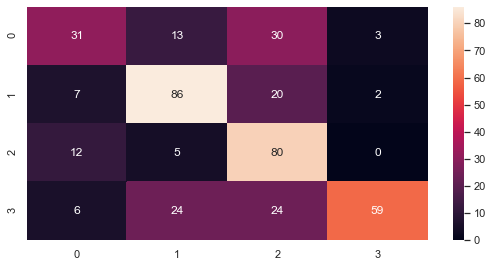

C:\Users\Habib\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)



Logistic RegressionClassifier: 

Confusion Matrix:
 [[ 71   2   2   2]
 [  2 107   2   4]
 [  0   0  97   0]
 [  2   2   0 109]]
Classification Report : 
               precision    recall  f1-score   support

       angry       0.95      0.92      0.93        77
       happy       0.96      0.93      0.95       115
         sad       0.96      1.00      0.98        97
   surprised       0.95      0.96      0.96       113

    accuracy                           0.96       402
   macro avg       0.95      0.95      0.95       402
weighted avg       0.96      0.96      0.96       402

Accuracy of Logistic Regression : 

Train Accuracy : 100.00000 %
Test Accuracy : 95.52239 % 

Train Recall :  1.0
Test Recall :  0.9552238805970149 

Test F1 :  0.9550056704616348
Test precison :  0.9552536140717919


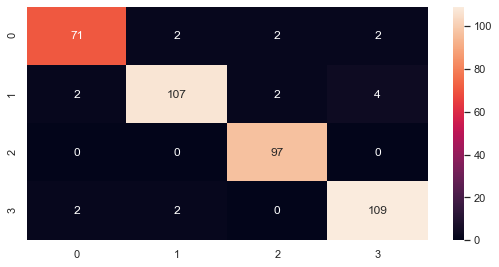


SVMClassifier: 

Confusion Matrix:
 [[ 73   4   0   0]
 [  2 109   2   2]
 [  0   0  97   0]
 [  4   0   0 109]]
Classification Report : 
               precision    recall  f1-score   support

       angry       0.92      0.95      0.94        77
       happy       0.96      0.95      0.96       115
         sad       0.98      1.00      0.99        97
   surprised       0.98      0.96      0.97       113

    accuracy                           0.97       402
   macro avg       0.96      0.97      0.96       402
weighted avg       0.97      0.97      0.97       402

Accuracy of SVM : 

Train Accuracy : 100.00000 %
Test Accuracy : 96.51741 % 

Train Recall :  1.0
Test Recall :  0.9651741293532339 

Test F1 :  0.9651832370207131
Test precison :  0.9653867419859906


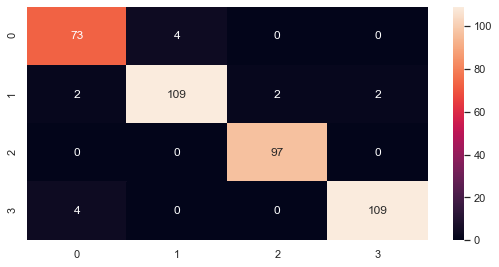


Random ForestClassifier: 

Confusion Matrix:
 [[ 71   6   0   0]
 [  6 107   0   2]
 [  0   0  94   3]
 [  2   0   0 111]]
Classification Report : 
               precision    recall  f1-score   support

       angry       0.90      0.92      0.91        77
       happy       0.95      0.93      0.94       115
         sad       1.00      0.97      0.98        97
   surprised       0.96      0.98      0.97       113

    accuracy                           0.95       402
   macro avg       0.95      0.95      0.95       402
weighted avg       0.95      0.95      0.95       402

Accuracy of Random Forest : 

Train Accuracy : 100.00000 %
Test Accuracy : 95.27363 % 

Train Recall :  1.0
Test Recall :  0.9527363184079602 

Test F1 :  0.9528622671640096
Test precison :  0.9532976300998303


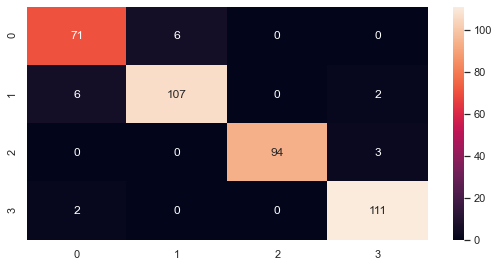


Naive BayesClassifier: 

Confusion Matrix:
 [[44 12 11 10]
 [23 72 11  9]
 [31  6 52  8]
 [28  7  7 71]]
Classification Report : 
               precision    recall  f1-score   support

       angry       0.35      0.57      0.43        77
       happy       0.74      0.63      0.68       115
         sad       0.64      0.54      0.58        97
   surprised       0.72      0.63      0.67       113

    accuracy                           0.59       402
   macro avg       0.61      0.59      0.59       402
weighted avg       0.64      0.59      0.61       402

Accuracy of Naive Bayes : 

Train Accuracy : 68.49088 %
Test Accuracy : 59.45274 % 

Train Recall :  0.6849087893864013
Test Recall :  0.5945273631840796 

Test F1 :  0.6074976829858137
Test precison :  0.6377827500204081


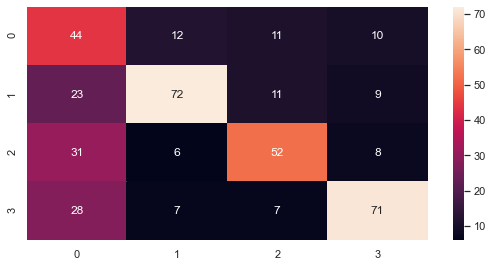


xgBootsClassifier: 

Confusion Matrix:
 [[ 55   9   7   6]
 [  4 100   6   5]
 [  0   5  90   2]
 [  0   6   4 103]]
Classification Report : 
               precision    recall  f1-score   support

       angry       0.93      0.71      0.81        77
       happy       0.83      0.87      0.85       115
         sad       0.84      0.93      0.88        97
   surprised       0.89      0.91      0.90       113

    accuracy                           0.87       402
   macro avg       0.87      0.86      0.86       402
weighted avg       0.87      0.87      0.86       402

Accuracy of xgBoots : 

Train Accuracy : 97.42952 %
Test Accuracy : 86.56716 % 

Train Recall :  0.9742951907131011
Test Recall :  0.8656716417910447 

Test F1 :  0.8641558271298245
Test precison :  0.869497478342197


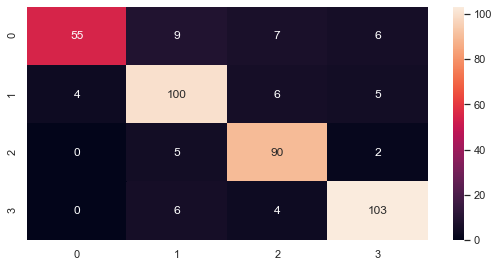


 ADABoostClassifier: 

Confusion Matrix:
 [[38 16 19  4]
 [31 77  5  2]
 [30  5 57  5]
 [17  5 16 75]]
Classification Report : 
               precision    recall  f1-score   support

       angry       0.33      0.49      0.39        77
       happy       0.75      0.67      0.71       115
         sad       0.59      0.59      0.59        97
   surprised       0.87      0.66      0.75       113

    accuracy                           0.61       402
   macro avg       0.63      0.60      0.61       402
weighted avg       0.66      0.61      0.63       402

Accuracy of  ADABoost : 

Train Accuracy : 76.69983 %
Test Accuracy : 61.44279 % 

Train Recall :  0.7669983416252073
Test Recall :  0.6144278606965174 

Test F1 :  0.6311832214686386
Test precison :  0.6635361277247492


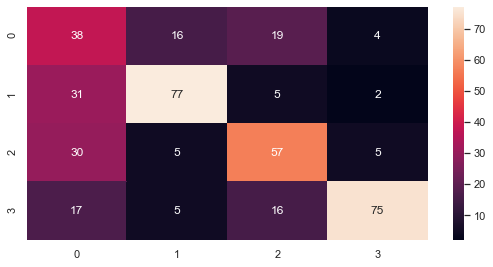


Gradient BoostClassifier: 

Confusion Matrix:
 [[ 71   4   0   2]
 [  4 103   6   2]
 [  3   0  94   0]
 [  0   0   2 111]]
Classification Report : 
               precision    recall  f1-score   support

       angry       0.91      0.92      0.92        77
       happy       0.96      0.90      0.93       115
         sad       0.92      0.97      0.94        97
   surprised       0.97      0.98      0.97       113

    accuracy                           0.94       402
   macro avg       0.94      0.94      0.94       402
weighted avg       0.94      0.94      0.94       402

Accuracy of Gradient Boost : 

Train Accuracy : 100.00000 %
Test Accuracy : 94.27861 % 

Train Recall :  1.0
Test Recall :  0.9427860696517413 

Test F1 :  0.9425824724871399
Test precison :  0.9434139309684558


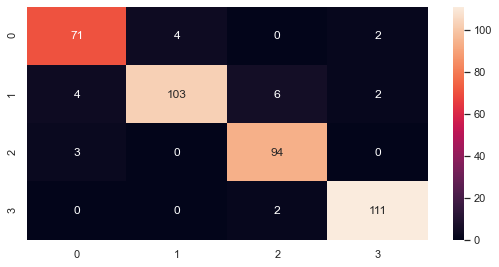


KNN classifier ( k = 5)


KNNClassifier: 

Confusion Matrix:
 [[35 23 17  2]
 [26 59 20 10]
 [18 19 57  3]
 [15 35 27 36]]
Classification Report : 
               precision    recall  f1-score   support

       angry       0.37      0.45      0.41        77
       happy       0.43      0.51      0.47       115
         sad       0.47      0.59      0.52        97
   surprised       0.71      0.32      0.44       113

    accuracy                           0.47       402
   macro avg       0.50      0.47      0.46       402
weighted avg       0.51      0.47      0.46       402

Accuracy of KNN : 

Train Accuracy : 70.48093 %
Test Accuracy : 46.51741 % 

Train Recall :  0.7048092868988391
Test Recall :  0.4651741293532338 

Test F1 :  0.4624844268555733
Test precison :  0.5075095507629263


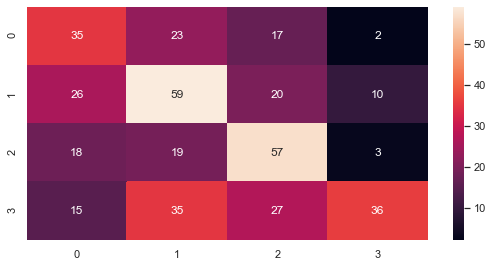


KNN classifier ( k = 7)


KNNClassifier: 

Confusion Matrix:
 [[36 18 19  4]
 [20 70 19  6]
 [23 17 50  7]
 [10 37 18 48]]
Classification Report : 
               precision    recall  f1-score   support

       angry       0.40      0.47      0.43        77
       happy       0.49      0.61      0.54       115
         sad       0.47      0.52      0.49        97
   surprised       0.74      0.42      0.54       113

    accuracy                           0.51       402
   macro avg       0.53      0.50      0.50       402
weighted avg       0.54      0.51      0.51       402

Accuracy of KNN : 

Train Accuracy : 68.98839 %
Test Accuracy : 50.74627 % 

Train Recall :  0.6898839137645107
Test Recall :  0.5074626865671642 

Test F1 :  0.5093795428223361
Test precison :  0.5398932315624047


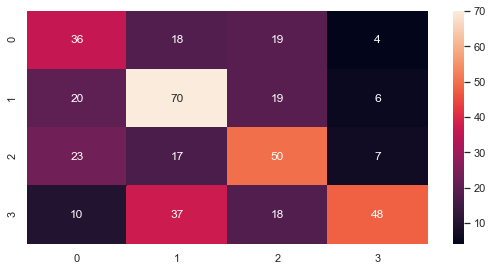


KNN classifier ( k = 9)


KNNClassifier: 

Confusion Matrix:
 [[29 24 18  6]
 [15 69 26  5]
 [24 15 54  4]
 [ 9 31 20 53]]
Classification Report : 
               precision    recall  f1-score   support

       angry       0.38      0.38      0.38        77
       happy       0.50      0.60      0.54       115
         sad       0.46      0.56      0.50        97
   surprised       0.78      0.47      0.59       113

    accuracy                           0.51       402
   macro avg       0.53      0.50      0.50       402
weighted avg       0.54      0.51      0.51       402

Accuracy of KNN : 

Train Accuracy : 62.52073 %
Test Accuracy : 50.99502 % 

Train Recall :  0.6252072968490879
Test Recall :  0.5099502487562189 

Test F1 :  0.5133897809355454
Test precison :  0.5436559474017191


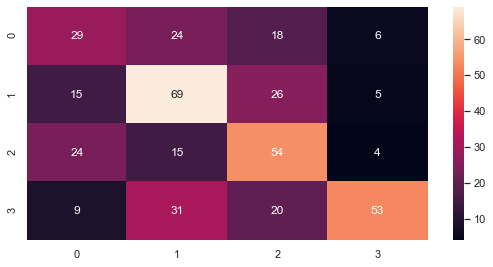


KNN classifier ( k = 19)


KNNClassifier: 

Confusion Matrix:
 [[26 26 19  6]
 [11 75 23  6]
 [15 19 58  5]
 [ 4 33 24 52]]
Classification Report : 
               precision    recall  f1-score   support

       angry       0.46      0.34      0.39        77
       happy       0.49      0.65      0.56       115
         sad       0.47      0.60      0.52        97
   surprised       0.75      0.46      0.57       113

    accuracy                           0.52       402
   macro avg       0.54      0.51      0.51       402
weighted avg       0.55      0.52      0.52       402

Accuracy of KNN : 

Train Accuracy : 59.36982 %
Test Accuracy : 52.48756 % 

Train Recall :  0.593698175787728
Test Recall :  0.5248756218905473 

Test F1 :  0.5222795784090438
Test precison :  0.5538630274910408


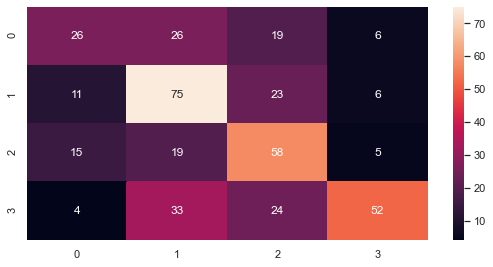

In [18]:
# Decision Tree Classifier:............................................................................

name = "Decision Tree"
dt = DecisionTreeClassifier(criterion="entropy", max_depth=5)
dt_acc = train_model(dt, name)


# Logistic Regression Final:..........................................................................

name = "Logistic Regression"
lr = LogisticRegression()
lr_acc = train_model(lr, name)


# SVM Classifier:.....................................................................................

name = "SVM"
svm = SVC(kernel='linear')
svm_acc = train_model(svm, name)


# Random Forest Classifier:..................................................................................

name = "Random Forest"
rn = RandomForestClassifier(n_estimators=90)
rn_acc = train_model(rn, name)


# Naive Bayes Classifier:........................................................................

name = "Naive Bayes"
nb = GaussianNB()
nb_acc = train_model(nb, name)


# xgBoost classifier:.........................................................................

name = "xgBoots"
xgb = XGBClassifier(n_estimators=10,objective ='binary:logistic',colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10,)
xgb_acc = train_model(xgb, name)


# ADABoost Classifier:.......................................

name = " ADABoost"
adab = AdaBoostClassifier()
adab_acc = train_model(adab, name)


# GradientBoost Classifier:.......................................

name = "Gradient Boost"
gb = GradientBoostingClassifier()
gb_acc = train_model(gb, name)

# Knn Classifier:..................................................................................

name = "KNN"
neighbors = [5, 7, 9, 19,]
k_pred = []

for k in neighbors:
    print(f"\nKNN classifier ( k = {k})\n")
    knn = KNeighborsClassifier(n_neighbors= k)
    knn_acc = train_model(knn, name)
    k_pred.append(knn_acc)
    


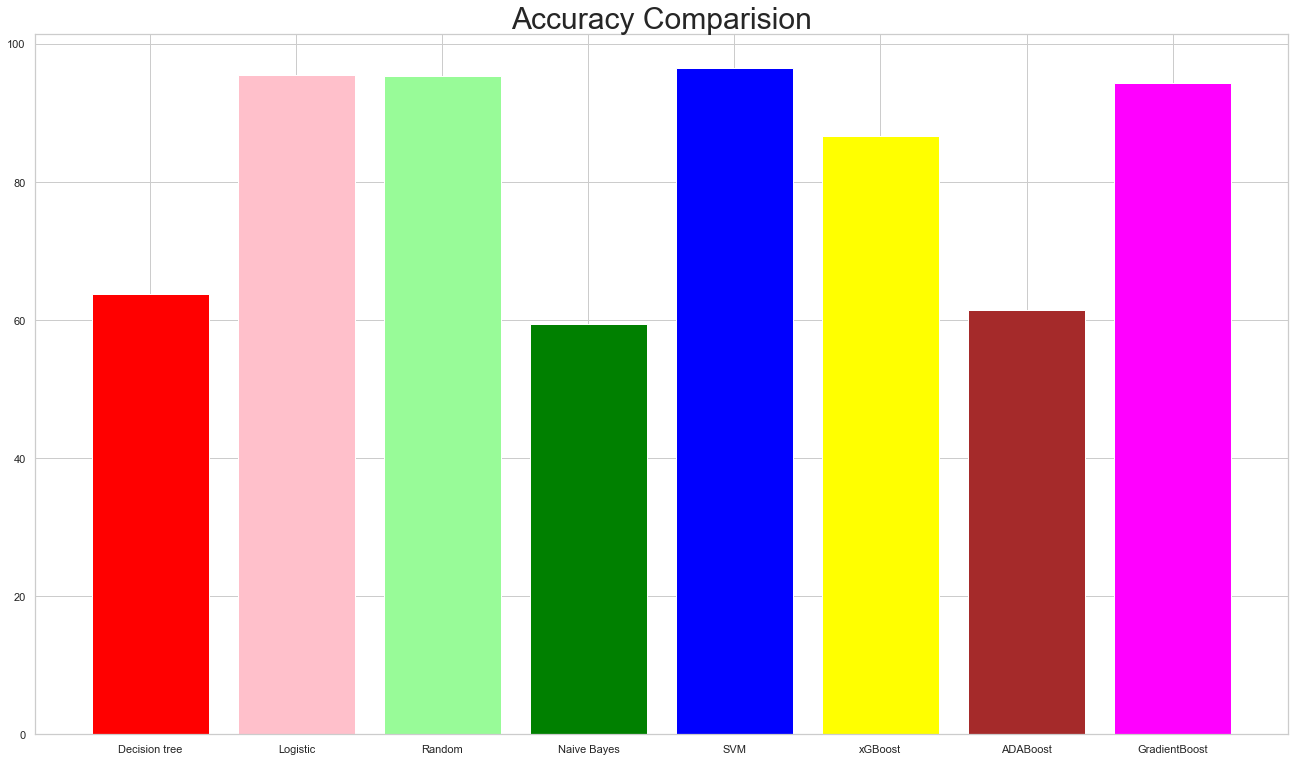

In [20]:
# Make a plot...........................................................................................

height = [dt_acc*100, lr_acc*100, rn_acc*100, nb_acc*100, svm_acc*100, xgb_acc*100, adab_acc*100,
          gb_acc*100]
bars = ('Decision tree', 'Logistic','Random', 'Naive Bayes','SVM', 'xGBoost', 'ADABoost',
        'GradientBoost')

y_pos = np.arange(len(bars))

plt.figure(figsize=(20, 12))
plt.bar(y_pos, height, color=['red', 'pink', 'palegreen', 'green', 'blue', 'yellow', 'brown','magenta'])
plt.xticks(y_pos, bars)
plt.title('Accuracy Comparision', size = 30)
plt.show()

# Classifier after tuning

In [6]:
def test(model, name):
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)
    
    print("\n"+ name + " Classifier: \n")

    test_matrics = confusion_matrix(y_test, test_pred)
    print("Confusion Matrix:\n", test_matrics)

    test_report = classification_report(y_test, test_pred)
    print("Classification Report : \n", test_report)
    
    test_acc = accuracy_score(y_test, test_pred)                     # test accuracy
    train_acc = accuracy_score(y_train, train_pred)
    
    print("Accuracy of " + name + " : \n")
          
    print('Train Accuracy : {:.5f} %'.format(train_acc * 100))
    print('Test Accuracy : {:.5f} % \n'.format(test_acc * 100))

    print('Train recall: ', recall_score(y_train, train_pred, average='macro'))
    print("Test recall:", recall_score(y_test, test_pred, average='macro'), '\n')
    
    print("Test f1:", f1_score(y_test, test_pred, average='macro'))
    print("Test precison : ", precision_score(y_test, test_pred, average='weighted'))
    
    style.use('fivethirtyeight')
    sns.set(style='whitegrid', color_codes=True, font_scale=1.2)   # 'font_scale' = size of label 
    
    plt.figure(figsize=(6,4))
    sns.heatmap(test_matrics, annot=True, annot_kws={"size": 17}, fmt = "d")
    plt.show()

    return test_acc

    
def save_model(model, name):
    with open(name, 'wb') as f:
        pickle.dump(model, f)
        print("model saved")


Decision Tree Classifier: 

Confusion Matrix:
 [[67  2  6  2]
 [ 2 99  6  8]
 [ 0  0 91  6]
 [10  6  2 95]]
Classification Report : 
               precision    recall  f1-score   support

       angry       0.85      0.87      0.86        77
       happy       0.93      0.86      0.89       115
         sad       0.87      0.94      0.90        97
   surprised       0.86      0.84      0.85       113

    accuracy                           0.88       402
   macro avg       0.87      0.88      0.88       402
weighted avg       0.88      0.88      0.88       402

Accuracy of Decision Tree : 

Train Accuracy : 100.00000 %
Test Accuracy : 87.56219 % 

Train recall:  1.0
Test recall: 0.8774629324614847 

Test f1: 0.8750176588976094
Test precison :  0.8768259826010231


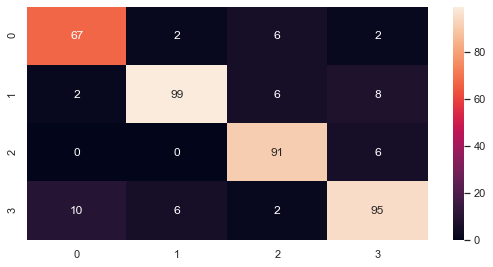

In [22]:
# ******************** Decision TreeFinal ******************

name = "Decision Tree"
dt_estimator = DecisionTreeClassifier(criterion='entropy', max_depth=15, max_features=8,
                       random_state=1)
dt_model = dt_estimator.fit(X_train, y_train)

dt_acc = test(dt_model, name)
# save_model(dt_model, 'model_decision_tree.pickle')


Logistic Regression Classifier: 

Confusion Matrix:
 [[ 77   0   0   0]
 [  2 109   2   2]
 [  0   0  97   0]
 [  4   0   0 109]]
Classification Report : 
               precision    recall  f1-score   support

       angry       0.93      1.00      0.96        77
       happy       1.00      0.95      0.97       115
         sad       0.98      1.00      0.99        97
   surprised       0.98      0.96      0.97       113

    accuracy                           0.98       402
   macro avg       0.97      0.98      0.97       402
weighted avg       0.98      0.98      0.98       402

Accuracy of Logistic Regression : 

Train Accuracy : 100.00000 %
Test Accuracy : 97.51244 % 

Train recall:  1.0
Test recall: 0.9781069642170065 

Test f1: 0.9746811224489795
Test precison :  0.9762141864281767


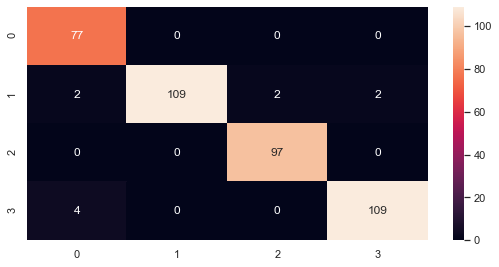

In [23]:
# ********************* Logistic Regression Final *****************************

name = "Logistic Regression"
lr_estimetor = LogisticRegression(C=0.6, solver='liblinear')

lr_model = lr_estimetor.fit(X_train, y_train)

lr_acc = test(lr_model, name)
# save_model(lr_model, 'model_logistic_regression.pickle')


SVM Classifier: 

Confusion Matrix:
 [[ 73   4   0   0]
 [  2 109   2   2]
 [  0   0  97   0]
 [  4   0   0 109]]
Classification Report : 
               precision    recall  f1-score   support

       angry       0.92      0.95      0.94        77
       happy       0.96      0.95      0.96       115
         sad       0.98      1.00      0.99        97
   surprised       0.98      0.96      0.97       113

    accuracy                           0.97       402
   macro avg       0.96      0.97      0.96       402
weighted avg       0.97      0.97      0.97       402

Accuracy of SVM : 

Train Accuracy : 100.00000 %
Test Accuracy : 96.51741 % 

Train recall:  1.0
Test recall: 0.9651199512299935 

Test f1: 0.9637619977140653
Test precison :  0.9653867419859906


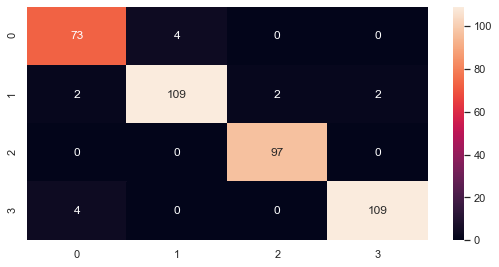

model saved


In [8]:
# ******************** SVM Final ******************

name = "SVM"
svm_estimetor = SVC(C=0.0001, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=7, kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

svm_estimetor.probability = True
svm_model = svm_estimetor.fit(X_train, y_train)

svm_acc = test(svm_model, name)
# save_model(svm_model, 'model_svm.pickle')


Random Forest Classifier: 

Confusion Matrix:
 [[ 71   4   0   2]
 [  4 107   4   0]
 [  0   0  97   0]
 [  2   0   0 111]]
Classification Report : 
               precision    recall  f1-score   support

       angry       0.92      0.92      0.92        77
       happy       0.96      0.93      0.95       115
         sad       0.96      1.00      0.98        97
   surprised       0.98      0.98      0.98       113

    accuracy                           0.96       402
   macro avg       0.96      0.96      0.96       402
weighted avg       0.96      0.96      0.96       402

Accuracy of Random Forest : 

Train Accuracy : 100.00000 %
Test Accuracy : 96.01990 % 

Train recall:  1.0
Test recall: 0.9587033974105924 

Test f1: 0.9577698604247277
Test precison :  0.9602345067100497


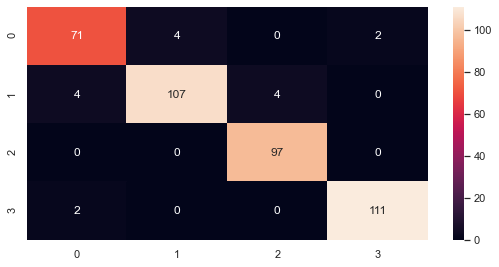

In [26]:
# ******************** Random Forest Final ******************

name = "Random Forest"
rf_estimetor = RandomForestClassifier(max_depth=10, min_samples_leaf=4, n_estimators=94,
                       random_state=137)

rf_model = rf_estimetor.fit(X_train, y_train)

rf_acc = test(rf_model, name)
# save_model(rf_model, 'model_random_forest.pickle')


xgBoost Classifier: 

Confusion Matrix:
 [[ 73   4   0   0]
 [  4 107   2   2]
 [  3   0  94   0]
 [  0   0   2 111]]
Classification Report : 
               precision    recall  f1-score   support

       angry       0.91      0.95      0.93        77
       happy       0.96      0.93      0.95       115
         sad       0.96      0.97      0.96        97
   surprised       0.98      0.98      0.98       113

    accuracy                           0.96       402
   macro avg       0.95      0.96      0.96       402
weighted avg       0.96      0.96      0.96       402

Accuracy of xgBoost : 

Train Accuracy : 100.00000 %
Test Accuracy : 95.77114 % 

Train recall:  1.0
Test recall: 0.9574649451412124 

Test f1: 0.9558106024145142
Test precison :  0.9581073934885235


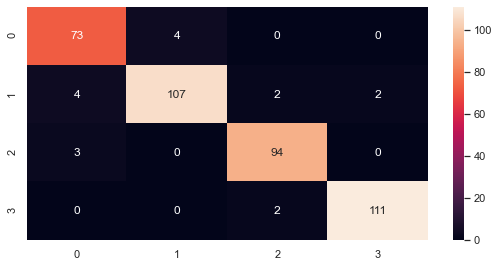

In [27]:
# ******************** xgBoost Final ******************

name = "xgBoost"
xgb_estimetor = XGBClassifier(base_score=0.5, booster=None, class_weight='balanced',
        colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.8, gamma=0, gpu_id=-1,
        importance_type='gain', interaction_constraints=None, learning_rate=0.1, max_delta_step=0,
        max_depth=10, min_child_weight=1, monotone_constraints=None, n_estimators=50, n_jobs=1,
        nthread=1, num_parallel_tree=1, objective='multi:softprob', random_state=0, reg_alpha=0,
        reg_lambda=1, scale_pos_weight=None, silent=True, subsample=0.5, tree_method=None,
        validate_parameters=False, verbosity=None)

xgb_model = xgb_estimetor.fit(X_train, y_train)

xgb_acc = test(xgb_model, name)
# save_model(rf_model, 'model_xgBoost.pickle')


Gradient Boosting Machine Classifier: 

Confusion Matrix:
 [[ 71   2   2   2]
 [  2 105   6   2]
 [  3   0  94   0]
 [  2   0   0 111]]
Classification Report : 
               precision    recall  f1-score   support

       angry       0.91      0.92      0.92        77
       happy       0.98      0.91      0.95       115
         sad       0.92      0.97      0.94        97
   surprised       0.97      0.98      0.97       113

    accuracy                           0.95       402
   macro avg       0.94      0.95      0.95       402
weighted avg       0.95      0.95      0.95       402

Accuracy of Gradient Boosting Machine : 

Train Accuracy : 100.00000 %
Test Accuracy : 94.77612 % 

Train recall:  1.0
Test recall: 0.9466236125607493 

Test f1: 0.9451207017051947
Test precison :  0.9487610272626856


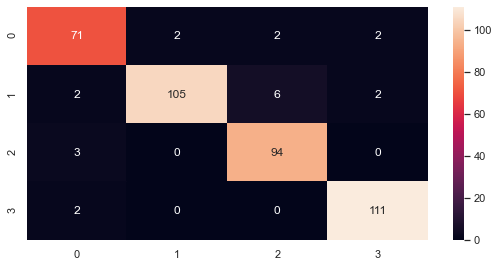

In [29]:
# ******************** Gradient Boosting MachineFinal ******************

name = "Gradient Boosting Machine"
gbm_estimetor = GradientBoostingClassifier(learning_rate=0.2, max_depth=2, n_estimators=120)

gbm_model = gbm_estimetor.fit(X_train, y_train)

gbm_acc = test(gbm_model, name)
# save_model(gbm_model, 'model_gradient_boosting_machine.pickle')


ADABoost Classifier: 

Confusion Matrix:
 [[60  8  7  2]
 [25 86  4  0]
 [23  0 73  1]
 [ 8  3  7 95]]
Classification Report : 
               precision    recall  f1-score   support

       angry       0.52      0.78      0.62        77
       happy       0.89      0.75      0.81       115
         sad       0.80      0.75      0.78        97
   surprised       0.97      0.84      0.90       113

    accuracy                           0.78       402
   macro avg       0.79      0.78      0.78       402
weighted avg       0.82      0.78      0.79       402

Accuracy of ADABoost : 

Train Accuracy : 88.64013 %
Test Accuracy : 78.10945 % 

Train recall:  0.8827369754656638
Test recall: 0.780083037591675 

Test f1: 0.7775380227695523
Test precison :  0.8187570951074923


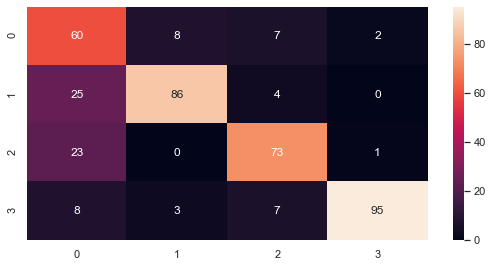

In [30]:
# ******************** ADABoost Final ******************

name = "ADABoost"
adab_estimetor = AdaBoostClassifier(n_estimators=120, random_state=10)

adab_model = adab_estimetor.fit(X_train, y_train)

adab_acc = test(adab_model, name)
# save_model(gbm_model, 'model_gradient_boosting_machine.pickle')


Naive Bayes Classifier: 

Confusion Matrix:
 [[44 12 11 10]
 [23 74 11  7]
 [31  6 53  7]
 [28  7  7 71]]
Classification Report : 
               precision    recall  f1-score   support

       angry       0.35      0.57      0.43        77
       happy       0.75      0.64      0.69       115
         sad       0.65      0.55      0.59        97
   surprised       0.75      0.63      0.68       113

    accuracy                           0.60       402
   macro avg       0.62      0.60      0.60       402
weighted avg       0.65      0.60      0.62       402

Accuracy of Naive Bayes : 

Train Accuracy : 68.32504 %
Test Accuracy : 60.19900 % 

Train recall:  0.6826029847317188
Test recall: 0.5974042922365631 

Test f1: 0.5999893501586426
Test precison :  0.6467568118871933


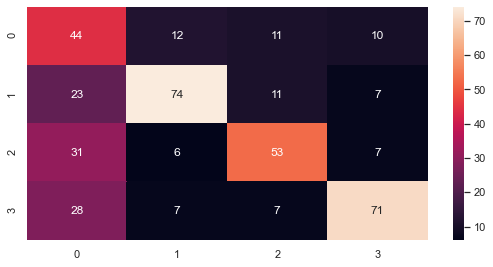

In [31]:
# ******************** Naive Bayes Final ******************

name = "Naive Bayes"
nb_estimetor = GaussianNB(var_smoothing=0.01)

nb_model = nb_estimetor.fit(X_train, y_train)

nb_acc = test(nb_model, name)
# save_model(knn_model, 'model_knn.pickle')


KNN Classifier: 

Confusion Matrix:
 [[28 25 19  5]
 [ 8 76 23  8]
 [18 20 56  3]
 [ 5 30 24 54]]
Classification Report : 
               precision    recall  f1-score   support

       angry       0.47      0.36      0.41        77
       happy       0.50      0.66      0.57       115
         sad       0.46      0.58      0.51        97
   surprised       0.77      0.48      0.59       113

    accuracy                           0.53       402
   macro avg       0.55      0.52      0.52       402
weighted avg       0.56      0.53      0.53       402

Accuracy of KNN : 

Train Accuracy : 61.60862 %
Test Accuracy : 53.23383 % 

Train recall:  0.6092995734476012
Test recall: 0.5199254056693278 

Test f1: 0.5211931842128272
Test precison :  0.562485538106233


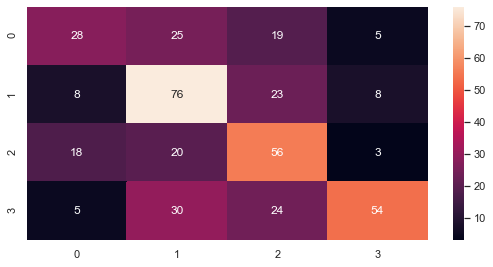

In [32]:
# ******************** KNN Final ******************

name = "KNN"
knn_estimetor = KNeighborsClassifier(metric='manhattan', n_neighbors=17)

knn_model = knn_estimetor.fit(X_train, y_train)

knn_acc = test(knn_model, name)
# save_model(knn_model, 'model_knn.pickle')

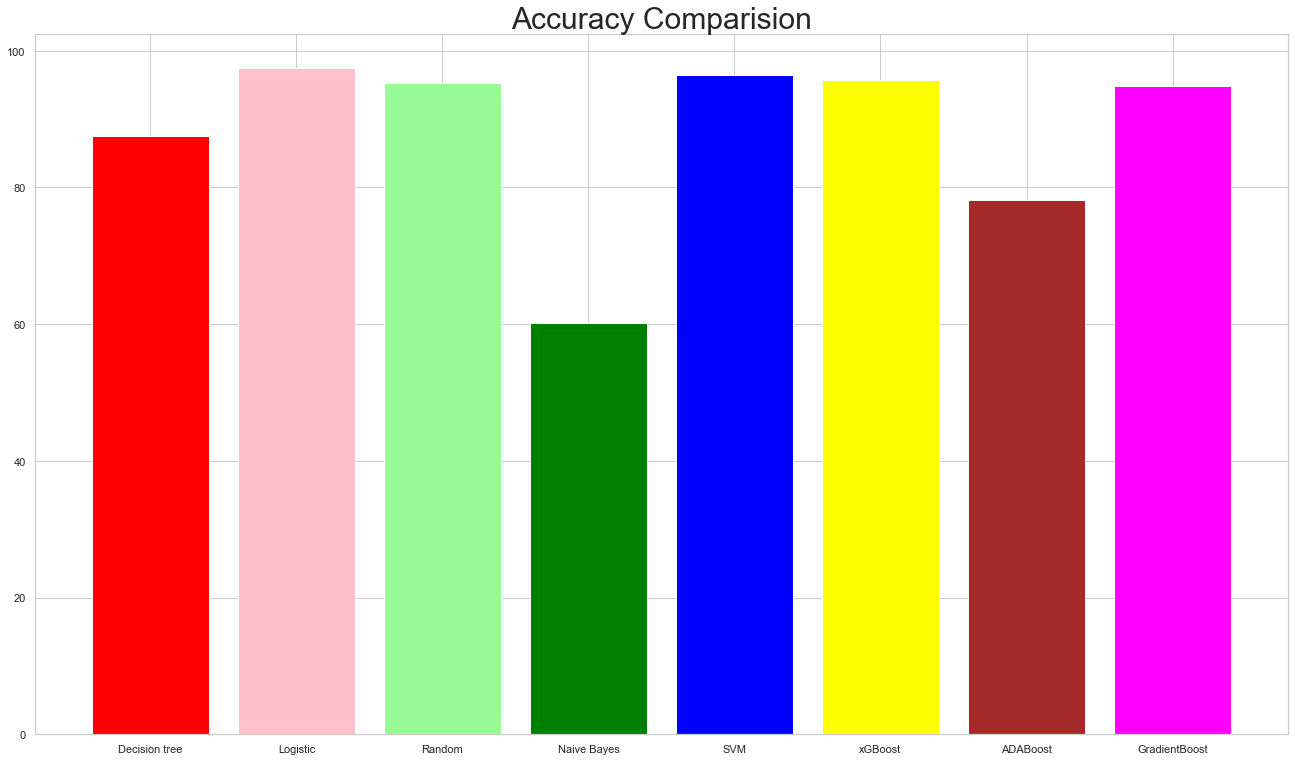

In [33]:
# Make a plot...........................................................................................

height = [dt_acc*100, lr_acc*100, rn_acc*100, nb_acc*100, svm_acc*100, xgb_acc*100, adab_acc*100, gbm_acc*100]

bars = ('Decision tree', 'Logistic', 'Random', 'Naive Bayes','SVM', 'xGBoost', 'ADABoost', 'GradientBoost')

y_pos = np.arange(len(bars))

plt.figure(figsize=(20, 12))
plt.bar(y_pos, height, color=['red', 'pink', 'palegreen', 'green', 'blue', 'yellow', 'brown', 'magenta'])
plt.xticks(y_pos, bars)
plt.title('Accuracy Comparision', size = 30)
plt.show()

# Tuning process section

In [ ]:
def test_tuning(grid_tree.best_estimator_):
    train_pred = grid_tree.best_estimator_.predict(X_train)
    y_pred = grid_tree.best_estimator_.predict(X_test)

    print('Train Accuracy: ', accuracy_score(y_train, train_pred ))
    print("Test Accuracy:", accuracy_score(y_test, y_pred), '\n')
    print('Train recall: ', recall_score(y_train, train_pred, average='macro'))
    print("Test recall:", recall_score(y_test, y_pred, average='macro'), '\n')
    print("Test f1:", f1_score(y_test, y_pred, average='macro'))

# Decision Tree - OK

In [ ]:

decision_tree = DecisionTreeClassifier(random_state=1)

# creating our parameters to test
param_dict={'max_depth': [14,15,17], 'min_samples_leaf':range(1,30,2), 'criterion': ['gini','entropy'],
           'max_features': range(0,9)}

#create the instance of GridSearchCV using the recall metric for our scoring. 
grid_tree= GridSearchCV(decision_tree, param_dict, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)

#fit the Gridsearch to our data
grid_tree.fit(X_train,y_train)

In [ ]:
print(grid_tree.best_score_)
print(grid_tree.best_params_)
print(grid_tree.best_estimator_)
print("n")

In [ ]:
test_tuning(grid_tree.best_estimator_)

model_dt = grid_tree.best_estimator_

# Logistic Regression - OK

In [ ]:
# Logistic Regression*****************************

with tf.device('/device:GPU:0'):

    lr = LogisticRegression()  # instantiate the model object
    #'newton-cg', 'lbfgs', 'liblinear'', 'sag', 'saga'
    param_dict={'solver':[ 'lbfgs', 'liblinear', 'sag', 'saga'], 'C': [0.5, 0.6, 0.7], 
               'penalty': ['l1', 'l2', 'elasticnet']}  # set parameters to be searched through GridSearch

    #create the instance of GridSearchCV using the recall metric for our scoring. 
    grid_tree= GridSearchCV(lr, param_dict, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
    #fit the Gridsearch to our data
    grid_tree.fit(X_train,y_train)
  

In [ ]:
print(grid_tree.best_score_)  # outputs the best metric score
print(grid_tree.best_params_)  # outputs the parameters with best result
print(grid_tree.best_estimator_)  # outputs the model with the best parameters

In [ ]:
test_tuning(grid_tree.best_estimator_)

# SVM - OK

In [ ]:
# SVM ******************************** 'sigmoid', 'precomputed'

svm = SVC()
# defining parameter range 
param_grid = {'C': [0.0001, 0.001, 0.01], 'gamma': [8,7,6], 'kernel': ['rbf','linear','poly']}

grid_tree=GridSearchCV(svm, param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
svm_model = grid_tree.fit(X_train, y_train)

In [ ]:
print(grid_tree.best_score_)
print(grid_tree.best_params_)
print(grid_tree.best_estimator_)

In [ ]:
test_tuning(grid_tree.best_estimator_)

# Random Forest - OK

In [ ]:
rfcc = RandomForestClassifier(random_state=137)
param_grid = {'max_depth':[8,9,10], 'n_estimators': [90,94,97 ], 
              'max_features': ['auto', 'log2', 'sqrt'], 'criterion': [ 'gini', 'entropy'],
              'min_samples_split': [ 2,3,4,5],'min_samples_leaf': [4,5,8]}

grid_tree=GridSearchCV(rfcc, param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
model = grid_tree.fit(X_train, y_train)

In [ ]:
print(grid_tree.best_score_)
print(grid_tree.best_params_)
print(grid_tree.best_estimator_)

In [ ]:
test_tuning(grid_tree.best_estimator_)

In [ ]:
print("Classification Report: \n\n", classification_report(y_test, y_pred))
print("Confusion Matrix: \n", metrics.confusion_matrix(y_test, y_pred))

# xgBoost - OK

In [ ]:
xgb = XGBClassifier(class_weight='balanced', objective='binary:logistic',silent=True, nthread=1)
# A parameter grid for XGBoost
param_grid = {
        'min_child_weight': [1], 'subsample': [0.5],'colsample_bytree': [0.8],
        'max_depth': [10], 'learning_rate': [0.1],'n_estimators':[50],
        # n_estimators=10, learning_rate= 0.02, 'gamma': [ 1],
        }
grid_tree=GridSearchCV(xgb, param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
grid_tree.fit(X_train, y_train)

In [ ]:
print(grid_tree.best_score_)
print(grid_tree.best_params_)
print(grid_tree.best_estimator_)

In [ ]:
test_tuning(grid_tree.best_estimator_)

# Gradient Boosting Machine - OK

In [ ]:
gb = GradientBoostingClassifier()
param_grid = [{'n_estimators': [120], 'learning_rate':[0.2],'max_depth': [2],
                   'min_samples_split': [2]}]

grid_tree=GridSearchCV(gb, param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
grid_tree.fit(X_train, y_train.ravel())

In [ ]:
print(grid_tree.best_score_)
print(grid_tree.best_params_)
print(grid_tree.best_estimator_)

In [ ]:
test_tuning(grid_tree.best_estimator_)
gb = grid_tree.best_estimator_

# ADABoost - OK

In [ ]:

ada = AdaBoostClassifier()
param_grid = {'n_estimators': [100,120], 'algorithm': ['SAMME','SAMME.R'],
              'learning_rate': [1.0], 'random_state':[10,20]}
grid_tree=GridSearchCV(ada, param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
grid_tree.fit(X_train, y_train)

In [ ]:
print(grid_tree.best_score_)
print(grid_tree.best_params_)
print(grid_tree.best_estimator_)

In [ ]:
test_tuning(grid_tree.best_estimator_)

# Naive Bayes - OK

In [ ]:
with tf.device('/device:GPU:0'):
    gnb = GaussianNB()
    # defining parameter range 
    param_grid = {'var_smoothing':[0.01,0.1,0.2]}
    grid_tree=GridSearchCV(gnb, param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
    grid_tree.fit(X_train, y_train)

In [ ]:
print(grid_tree.best_score_)
print(grid_tree.best_params_)
print(grid_tree.best_estimator_)

test_tuning(grid_tree.best_estimator_)
nb= grid_tree.best_estimator_

# KNN - OK

In [ ]:
knn = KNeighborsClassifier()
param_dict = {'n_neighbors': range(3,30, 2), 'metric': ['manhattan','euclidean','minkowski'],
              'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}
grid_tree= GridSearchCV(knn, param_dict, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
grid_tree.fit(X_train, y_train)

In [ ]:
print(grid_tree.best_score_)
print(grid_tree.best_params_)
print(grid_tree.best_estimator_)

In [ ]:
test_tuning(grid_tree.best_estimator_)
kn= grid_tree.best_estimator_